# Experimental Design on Multilayer Preceptron

This notebook performs the analysis and experimental design on the Multilayer Preceptron trained on Fashion-MNIST dataset. 
It automatically records the train/test accuracy of MLP trained with different portions of datasets (10% ... 100%). 


## Introduction

- Model: a multilayer preceptron that consists of four linear layer with ReLU activation functions. 
```
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
```
- Dataset: Fashion MNIST dataset, with 60,000 training samples and 10,000 testing samples. Each sample is a 28 x 28 grayscale image, that is out of the 10 classes: {"T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"}

To run this notebook, we can simply edit the `config` dictionary and run the pipeline. Model performances, metrics and stats will be automatically logged. Adjust the `sls` parameter in `config` to use different portion of training dataset.

**Note**: This notebook uses `wandb` to automatically logs the model performance. Following the official tutorial of `wandb`, this notebook integrates `wandb` with a multilayer preceptron model trained on Fashion-MNIST dataset. Before running this notebook, make sure
```bash
pip install wandb
```

In [57]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

# from tqdm.notebook import tqdm # progress bar

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [58]:
train_acc = []

## Preliminaries
We must login to wandb account, in order to record our training on the platform's dashborad. Make sure to install wandb library in our virtual conda environment. 

In [59]:
import wandb
wandb.login()

True

## Define Data Loading and Model

In [60]:
# Get training and testing data with config (slice)
def get_data(sls=5, train=True):
    
    full_dataset = datasets.FashionMNIST(
        root="data",
        train=train,
        download=True,
        transform=ToTensor(),
    )
    # equiv to slicing iwth [::slice]
    sub_dataset = Subset(full_dataset, indices=range(0, int(sls * len(full_dataset)), 1))
    
    return sub_dataset

# Make the dataloader with config (dataset, batch_size
def make_loader(dataset, batch_size):
    
    loader = DataLoader(dataset=dataset, batch_size=batch_size)
    return loader

In [61]:
# Define model: a simple multilayer preceptron
class MLP(nn.Module):
    def __init__(self, kernels, classes=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, kernels[0]),
            nn.ReLU(),
            nn.Linear(kernels[0], kernels[1]),
            nn.ReLU(),
            nn.Linear(kernels[1], kernels[2]),
            nn.ReLU(),
            nn.Linear(kernels[2], classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## Define Training Logic

`wandb.watch` will log the gradients and the parameters of your model, every `log_freq` steps of training.

In [62]:
def train(model, loader, criterion, optimizer, config):
    
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)
    
    # Run training and track with wandb
    total_batches = len(loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in range(config.epochs):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 100) == 0:
                train_log(loss, example_ct, epoch)

def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass 
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass 
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

`wandb.log` records the reported metrics to their server. 

In [63]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

## Define Testing Logic

Once the model is done training, we want to test it: run it against some fresh data from production.

We can save the model's architecture and final parameters to disk. We'll `export` our model in the
[Open Neural Network eXchange (ONNX) format](https://onnx.ai/).

Passing that filename to `wandb.save` ensures that the model parameters are saved to W&B's servers: no more losing track of which `.h5` or `.pb` corresponds to which training runs!

In [64]:
def test(model, test_loader):
    
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader: #TODO
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"train images: {100 * correct / total}%")
        
        wandb.log({"train_accuracy": correct / total})
        train_acc.append(correct / total)

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

## Define the experiment and pipeline

### Make

To ensure the values we chose and logged are always the ones that get used
in our model, we use the `wandb.config` copy of your object.

In [65]:
def make(config):
    # Make the data, TODO: both data are training 6000 data
    train, test = get_data(train=True, sls = config.sls), get_data(train=True, sls= config.sls)
    train_loader = make_loader(train, batch_size=config.batch_size)
    test_loader = make_loader(test, batch_size=config.batch_size)

    # Make the model
    model = MLP(config.kernels, config.classes).to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, test_loader, criterion, optimizer

### Pipeline

The overall pipeline is structured as the following:
1. we first `make` a model, plus associated data and optimizer, then
2. we `train` the model accordingly and finally
3. `test` it to see how training went.

In [66]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="mlp-final", config=hyperparameters):
      
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config

        # make the model, data, and optimization problem
        model, train_loader, test_loader, criterion, optimizer = make(config)
        print(model)

        # and use them to train the model
        train(model, train_loader, criterion, optimizer, config)

        # and test its final performance
        test(model, test_loader)

    return model

### Run the Model 

- Config: Hyperparameters and metadata for our model is stored in a dictionary `config`.
- Pipeline: build, train and analyze the model with pipline

In [67]:
# configurations
config = dict(
    epochs=10,
    classes=10,
    kernels=[200, 128, 128],
    batch_size=64,
    learning_rate=0.001,
    sls = 0.1,
    dataset="Fashion-MNIST",
    architecture="MLP"
)

# Build, train and analyze the model with the pipeline
portions = [0.1, 0.3, 0.5, 0.7, 1]
for sls in portions:
    config['sls'] = sls
    model = model_pipeline(config)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
Loss after 06320 examples: 0.937
Loss after 12704 examples: 0.408
Loss after 19088 examples: 0.460
Loss after 25472 examples: 0.361
Loss after 31856 examples: 0.543
Loss after 38240 examples: 0.480
Loss after 44624 examples: 0.347
Loss after 51008 examples: 0.419
Loss after 57392 examples: 0.364
Accuracy of the model on the 6000 train images: 89.33333333333333%


epoch,▁▂▃▄▅▅▆▇█
loss,█▂▂▁▃▃▁▂▁
train_accuracy,▁
epoch,9
loss,0.36394
train_accuracy,0.89333


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
Loss after 06336 examples: 0.709
Loss after 12736 examples: 0.529
Loss after 19088 examples: 0.538
Loss after 25488 examples: 0.414
Loss after 31888 examples: 0.398
Loss after 38240 examples: 0.511
Loss after 44640 examples: 0.376
Loss after 51040 examples: 0.415
Loss after 57392 examples: 0.463
Loss after 63792 examples: 0.355
Loss after 70192 examples: 0.278
Loss after 76544 examples: 0.305
Loss after 82944 examples: 0.320
Loss after 89344 examples: 0.432
Loss after 95696 examples: 0.386
Loss after 102096 examples: 0.266
Loss after 108448 examples: 0.264
Loss after 114848 examples: 0.230
Loss after 12124

epoch,▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇███
loss,█▅▆▄▄▅▃▄▅▃▂▂▃▄▃▂▂▁▂▂▃▂▂▂▂▅▂▁
train_accuracy,▁
epoch,9
loss,0.21095
train_accuracy,0.89706


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
Loss after 06336 examples: 0.785
Loss after 12736 examples: 0.550
Loss after 19136 examples: 0.743
Loss after 25536 examples: 0.539
Loss after 31920 examples: 0.408
Loss after 38320 examples: 0.534
Loss after 44720 examples: 0.420
Loss after 51120 examples: 0.439
Loss after 57520 examples: 0.357
Loss after 63904 examples: 0.698
Loss after 70304 examples: 0.388
Loss after 76704 examples: 0.311
Loss after 83104 examples: 0.396
Loss after 89504 examples: 0.486
Loss after 95888 examples: 0.387
Loss after 102288 examples: 0.275
Loss after 108688 examples: 0.213
Loss after 115088 examples: 0.192
Loss after 12147

/global/homes/m/maoli/.conda/envs/tutorial/lib/python3.8/site-packages/wandb/wandb_torch.py:222: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if flat.shape == torch.Size([0]):
/global/homes/m/maoli/.conda/envs/tutorial/lib/python3.8/site-packages/wandb/wandb_torch.py:225: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  tmin = flat.min().item()
/global/homes/m/maoli/.conda/envs/tutorial/lib/python3.8/site-packages/wandb/wandb_torch.py:226: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
loss,█▆█▅▄▅▄▄▇▄▃▄▅▄▂▂▂▃▃▂▃▅▂▃▃▄▂▄▃▃▂▃▁▂▂▄▂▃▂▃
train_accuracy,▁
epoch,9
loss,0.22377
train_accuracy,0.90287


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
Loss after 06336 examples: 0.719
Loss after 12736 examples: 0.567
Loss after 19136 examples: 0.745
Loss after 25536 examples: 0.493
Loss after 31936 examples: 0.396
Loss after 38336 examples: 0.393
Loss after 44688 examples: 0.482
Loss after 51088 examples: 0.393
Loss after 57488 examples: 0.543
Loss after 63888 examples: 0.457
Loss after 70288 examples: 0.577
Loss after 76688 examples: 0.346
Loss after 83088 examples: 0.398
Loss after 89440 examples: 0.520
Loss after 95840 examples: 0.373
Loss after 102240 examples: 0.388
Loss after 108640 examples: 0.472
Loss after 115040 examples: 0.324
Loss after 12144

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
loss,█▆▅▄▅▆▅▃▆▄▅▃▂▂▂▅▂▃▃▄▃▃▁▂▃▂▂▂▃▃▄▁▁▂▁▁▃▄▁▂
train_accuracy,▁
epoch,9
loss,0.18366
train_accuracy,0.90719


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
Loss after 06336 examples: 0.692
Loss after 12736 examples: 0.550
Loss after 19136 examples: 0.731
Loss after 25536 examples: 0.512
Loss after 31936 examples: 0.408
Loss after 38336 examples: 0.380
Loss after 44736 examples: 0.302
Loss after 51136 examples: 0.392
Loss after 57536 examples: 0.388
Loss after 63904 examples: 0.621
Loss after 70304 examples: 0.414
Loss after 76704 examples: 0.334
Loss after 83104 examples: 0.403
Loss after 89504 examples: 0.544
Loss after 95904 examples: 0.286
Loss after 102304 examples: 0.424
Loss after 108704 examples: 0.420
Loss after 115104 examples: 0.214
Loss after 12147

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
loss,██▄▄▇▄▃▅▃▃▇▃▅▄▂▄▄▄▃▂▃▁▂▄▂▃▃▃▁▃▄▄▂▃▂▃▃▁▂▂
train_accuracy,▁
epoch,9
loss,0.23662
train_accuracy,0.91188


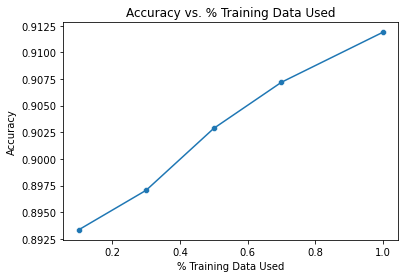

In [77]:
import seaborn as sns
plt.title("Accuracy vs. % Training Data Used")
plt.xlabel("% Training Data Used")
plt.ylabel("Accuracy")
sns.scatterplot(x=portions, y=train_acc)
sns.lineplot(x=portions, y=train_acc);